In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, csr_matrix


%matplotlib inline

In [129]:
tops=pd.read_csv(r'D:\jonahfull.csv')
small=tops.head()

In [130]:
tops.head()

,api,formation,depth,ssdepth,normd
0,3521913,WASATCH,0,7281,0
1,3521913,LANCE,9285,-2004,-4.633233533
2,3521913,LANCE - OVER PRESSURE,9760,-2479,-3.9370714
3,3521913,JONAH,11227,-3946,-2.845159655
4,3521913,YELLOW POINT,11793,-4512,-2.613696809


In [131]:
data=np.asarray(tops[['api', 'formation', 'depth']])

In [132]:
n_wells = tops.api.unique().shape[0]
n_formations = tops.formation.unique().shape[0]

print('Number of wells: {}'.format(n_wells))
print('Number of formations: {}'.format(n_formations))
print('Sparsity: {:4.3f}%'.format(float(tops.shape[0]) / float(n_wells*n_formations) * 100))

Number of wells: 2861
Number of formations: 442
Sparsity: 1.180%


In [133]:
formation_to_idx = {}
idx_to_formation = {}
for (idx, formation) in enumerate(tops.formation.unique().tolist()):
    formation_to_idx[formation] = idx
    idx_to_formation[idx] = formation
    
api_to_idx = {}
idx_to_api = {}
for (idx, api) in enumerate(tops.api.unique().tolist()):
    api_to_idx[api] = idx
    idx_to_api[idx] = api

In [134]:
def map_ids(row, mapper):
    return mapper[row]
import scipy.sparse as sparse


In [135]:
#%%timeit
J = tops.api.apply(map_ids, args=[api_to_idx]).as_matrix()
I = tops.formation.apply(map_ids, args=[formation_to_idx]).as_matrix()
V = tops.depth.astype(int)#/max(tops.depth.astype(int))
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

In [136]:
print('Number of data points: {}'.format(n_wells*n_formations))

Number of data points: 1264562


In [444]:
squirrel=[]
from scipy import spatial

for i in range(441):
    squirrel.append(1-spatial.distance.cosine(formation_factors[:,1],formation_factors[:,i]))

In [445]:
tops.formation.unique()[np.where(np.asarray(squirrel)>0.98)]


array(['LANCE', 'BOIS MARKER', 'LANCE YELLOW POINT', 'SURFACE',
       'LANCE B COAL', 'LANCE MIDDLE COAL', 'UPPER LANCE B', 'T UNNAMED',
       'JONAH - 1ST', 'JONAH SANDSTONE', 'WARDELL/LANCE', 'JONAH/ LANCE'],
      dtype=object)

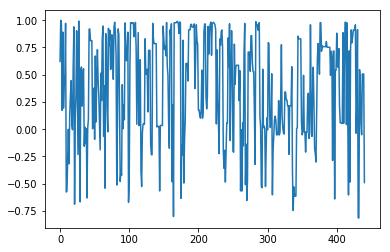

In [446]:
plt.plot(squirrel)

In [28]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.prediction_algorithms.matrix_factorization import SVD


# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(tops[['api', 'formation', 'depth']], reader)
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)
data

RMSE: 5915.3027


In [32]:
import implicit

In [150]:
model = implicit.als.AlternatingLeastSquares(factors=30)

In [151]:
model.fit(likes)

In [152]:
user_items = likes.T.tocsr()

In [153]:
recommendations = model.recommend(0, user_items)

In [154]:
likes

<442x2861 sparse matrix of type '<class 'numpy.float64'>'
	with 14804 stored elements in Compressed Sparse Row format>

In [155]:
recommendations

[(57, 0.8961089),
 (10, 0.8462074),
 (9, 0.83976054),
 (8, 0.79854),
 (22, 0.79053617),
 (244, 0.65557694),
 (11, 0.64325),
 (119, 0.63639545),
 (36, 0.5614818),
 (120, 0.55520636)]

In [147]:
likes.T.tocsr().todense()[0]
np.mean([9285.,  9760., 11227., 11793., 12139., 12477.])

11113.5

In [127]:
tops[tops['api']==3521913]

,api,formation,depth,ssdepth
0,3521913,WASATCH,0,7281
1,3521913,LANCE,9285,-2004
2,3521913,JONAH,11227,-3946
3,3521913,YELLOWPOINT,11793,-4512
4,3521913,WARDELL,12139,-4858
5,3521913,MESAVERDE,12477,-5196


In [159]:
tops.formation.unique()[22]

'TD'

In [169]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
  

In [170]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [172]:
MF_ALS = ExplicitMF(likes, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]


In [174]:
MF_ALS